In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import plotly.figure_factory as ff


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Define the path to the desired folder
folder_path = '/content/drive/MyDrive/emotions'

# Select the folders you want to use
selected_folders = ['happy', 'sad', 'neutral', 'angry']


In [26]:
data_dir = '/content/drive/MyDrive/emotions'  # Sesuaikan dengan direktori tempat data Anda disimpan

# Verify if the selected folders contain images
for folder in selected_folders:
    folder_path = os.path.join(data_dir, folder)
    if not os.path.exists(folder_path) or len(os.listdir(folder_path)) == 0:
        print(f"Warning: Folder {folder} is empty or does not exist.")


In [30]:
import os

# Define the path to the desired parent folder
parent_folder_path = '/content/drive/MyDrive/emotions'

# Select the folders you want to use
selected_folders = ['happy', 'sad', 'neutral', 'angry']

# Check availability of files and count the number of files in each selected folder
for folder in selected_folders:
    folder_path = os.path.join(parent_folder_path, folder)
    if os.path.exists(folder_path) and os.listdir(folder_path):
        file_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
        print(f"Folder '{folder}' contains {file_count} files.")
    else:
        print(f"Folder '{folder}' is empty or does not exist.")


Folder 'happy' contains 261 files.
Folder 'sad' contains 134 files.
Folder 'neutral' contains 105 files.
Folder 'angry' contains 186 files.


In [31]:
# Load and preprocess the data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create data generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    classes=selected_folders,  # Filter only selected folders
    class_mode='categorical',
    batch_size=16,  # Reduced batch size
    shuffle=True,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    classes=selected_folders,  # Filter only selected folders
    class_mode='categorical',
    batch_size=16,  # Reduced batch size
    shuffle=True,
    subset='validation'
)


Found 548 images belonging to 4 classes.
Found 134 images belonging to 4 classes.


In [32]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Change number of outputs to 4
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [55]:
# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_optimal.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model without early stopping
history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=80,
    callbacks=[checkpoint]
)


Epoch 1/80
35/35 [==============================] - ETA: 0s - loss: 0.4177 - accuracy: 0.8449
Epoch 1: val_accuracy improved from -inf to 0.80597, saving model to model_optimal.h5
35/35 [==============================] - 8s 164ms/step - loss: 0.4177 - accuracy: 0.8449 - val_loss: 0.4946 - val_accuracy: 0.8060
Epoch 2/80


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



35/35 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.8905
Epoch 2: val_accuracy did not improve from 0.80597
35/35 [==============================] - 4s 106ms/step - loss: 0.3347 - accuracy: 0.8905 - val_loss: 0.4531 - val_accuracy: 0.7761
Epoch 3/80
35/35 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9215
Epoch 3: val_accuracy improved from 0.80597 to 0.82090, saving model to model_optimal.h5
35/35 [==============================] - 5s 154ms/step - loss: 0.2395 - accuracy: 0.9215 - val_loss: 0.5000 - val_accuracy: 0.8209
Epoch 4/80
35/35 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9361
Epoch 4: val_accuracy did not improve from 0.82090
35/35 [==============================] - 4s 115ms/step - loss: 0.2013 - accuracy: 0.9361 - val_loss: 0.6202 - val_accuracy: 0.7836
Epoch 5/80
35/35 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9635
Epoch 5: val_accuracy did not improve from 0.82090


In [56]:
# Evaluate the model on the validation data
cnn_model.load_weights('model_optimal.h5')
validation_loss, validation_accuracy = cnn_model.evaluate(validation_generator)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')


9/9 [==============================] - 1s 79ms/step - loss: 0.7246 - accuracy: 0.8284
Validation Loss: 0.724563717842102
Validation Accuracy: 0.8283582329750061


In [63]:
# Predict on validation data using the trained model
Y_pred = cnn_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Print classification report
report = classification_report(y_true, y_pred, target_names=selected_folders)
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=selected_folders, columns=selected_folders)

# Plot confusion matrix
fig = ff.create_annotated_heatmap(
    z=cm_df.values,
    x=list(cm_df.columns),
    y=list(cm_df.index),
    annotation_text=cm_df.values,
    colorscale='Blues'
)
fig.update_layout(title='Confusion Matrix', xaxis_title='Predicted Label', yaxis_title='True Label')
fig.show()


11/11 [==============================] - 7s 682ms/step
              precision    recall  f1-score   support

       happy       0.98      0.99      0.98       259
         sad       1.00      0.91      0.95       133
     neutral       0.94      0.94      0.94       104
       angry       0.94      0.98      0.96       186

    accuracy                           0.97       682
   macro avg       0.97      0.96      0.96       682
weighted avg       0.97      0.97      0.97       682



1/1 [==============================] - 0s 123ms/step


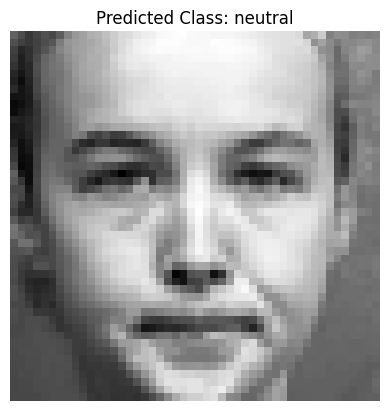

The predicted class for the new image is: neutral


In [36]:
def load_and_preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to create batch of size 1
    return img_array

def predict_image_class(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array).argmax(axis=1)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]

    # Display the image and prediction
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

new_image_path = '/content/drive/MyDrive/emotions/neutral/S139_002_00000011.png'  # Path to the new image
predicted_class = predict_image_class(cnn_model, new_image_path, train_generator.class_indices)
print(f'The predicted class for the new image is: {predicted_class}')


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from IPython.display import display
from ipywidgets import FileUpload
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to create batch of size 1
    return img_array

# Function to predict the image class
def predict_image_class(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array).argmax(axis=1)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]

    # Display the image and prediction
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class


In [38]:
# Load your model here
cnn_model = load_model('/content/model_optimal.h5')


In [39]:
# Define the selected classes
selected_classes = ['happy', 'sad', 'neutral', 'angry']

# Define ImageDataGenerator to fetch class indices for selected classes
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    classes=selected_classes,
    class_mode='categorical',
    shuffle=True
)
class_indices = data_generator.class_indices


Found 682 images belonging to 4 classes.


FileUpload(value={}, accept='.png, .jpg, .jpeg', description='Upload')

1/1 [==============================] - 0s 29ms/step


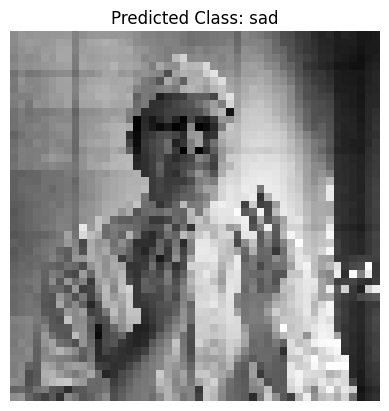

The predicted class for the new image is: sad
1/1 [==============================] - 0s 21ms/step


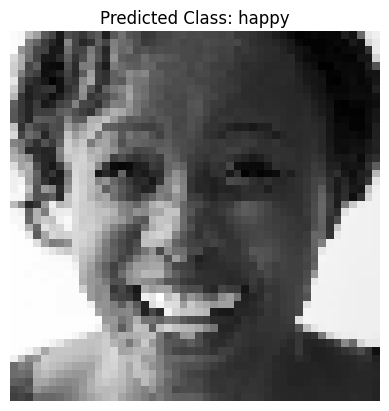

The predicted class for the new image is: happy
1/1 [==============================] - 0s 31ms/step


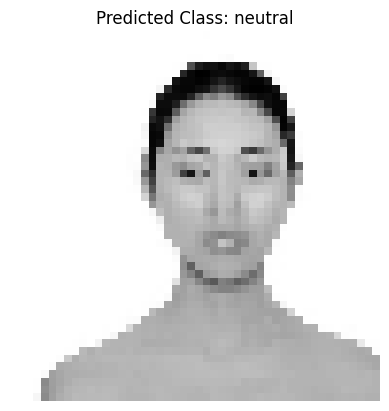

The predicted class for the new image is: neutral
1/1 [==============================] - 0s 23ms/step


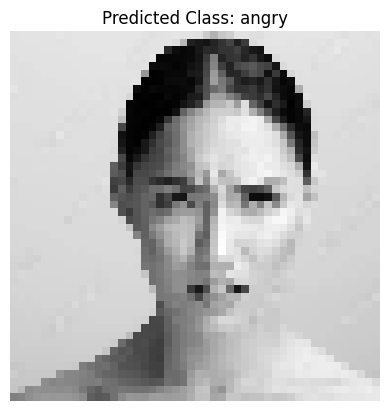

The predicted class for the new image is: angry


In [64]:
upload = FileUpload(accept='.png, .jpg, .jpeg', multiple=False)
display(upload)

def on_upload_change(change):
    if upload.value:
        uploaded_file = list(upload.value.values())[0]
        with open('uploaded_image.png', 'wb') as f:
            f.write(uploaded_file['content'])
        predicted_class = predict_image_class(cnn_model, 'uploaded_image.png', class_indices)
        print(f'The predicted class for the new image is: {predicted_class}')
    else:
        print("Please upload an image first.")

upload.observe(on_upload_change, names='value')


FileUpload(value={}, accept='.png, .jpg, .jpeg', description='Upload')

1/1 [==============================] - 0s 41ms/step


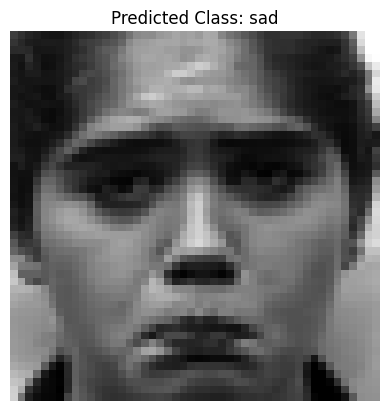

The predicted class for the new image is: sad
1/1 [==============================] - 0s 33ms/step


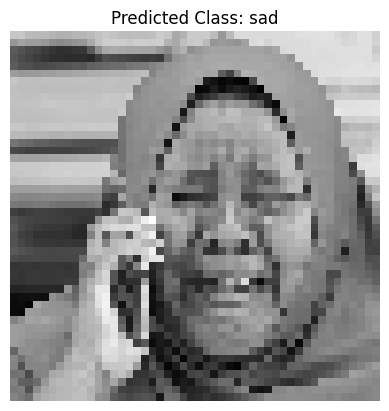

The predicted class for the new image is: sad


In [43]:
# File upload widget
upload = FileUpload(accept='.png, .jpg, .jpeg', multiple=False)
display(upload)

def on_upload_change(change):
    uploaded_file = list(upload.value.values())[0]
    with open('uploaded_image.png', 'wb') as f:
        f.write(uploaded_file['content'])
    predicted_class = predict_image_class(cnn_model, 'uploaded_image.png', class_indices)
    print(f'The predicted class for the new image is: {predicted_class}')

upload.observe(on_upload_change, names='value')
